# Sentiment Analysis

1. Scaled representation of : `pos`, `neg`, `neutral` [done]
2. Aspect-based analysis: which particular aspects or features are mentioned in a positive, neutral, or negative way. []
3. Semantic Clustering []
4. Feature Analysis []
5. Aspect Similaarity co-occurance
6. Emotion aspect co-occurance

   ======

1. Overall sentiment [done]
2. Sentiment by floor and space [done]
3. Sentiment by type of space i.e. group vs individual [done]
4. Sentiment by topic

In [1]:
import string

import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

import nltk
# from nltk.corpus import stopwords
# from nltk.corpus import wordnet
# from nltk.tokenize import word_tokenize, sent_tokenize
# from nltk.stem.wordnet import WordNetLemmatizer 

# import stanfordnlp

from transformers import pipeline
from sklearn.preprocessing import MinMaxScaler
from nltk.sentiment import SentimentIntensityAnalyzer
from pyabsa import ATEPCCheckpointManager


/bin/sh: nvidia-smi: command not found


No CUDA GPU found in your device
Version 0.9.7 of metric_visualizer is outdated. Version 0.9.9 was released Tuesday July 04, 2023.
[2023-08-09 15:02:01] (2.3.1) PyABSA(2.3.1): If your code crashes on Colab, please use the GPU runtime. Then run "pip install pyabsa[dev] -U" and restart the kernel.
Or if it does not work, you can use v1.16.27




Try to downgrade transformers<=4.29.0.






In [2]:
# Settings
# stanfordnlp.download('en')
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/multiprocessing/pool.py:265: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=1>
  _warn(f"unclosed running multiprocessing pool {self!r}",


In [3]:
drop_col_emo=['occupation', 'usage', 'recruitment']

# Students at LAB42

In [26]:
emo_sl42 = pd.read_csv('data/lab42_cleaned_data.csv', index_col=0).drop(columns = drop_col_emo, axis=1).dropna(subset=['emotion'])

## Emotions: LLM-based Overall Sentiment Analysis

In [27]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
sentiment_task = pipeline("sentiment-analysis", model=MODEL, tokenizer=MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
def sentiment_analysis(sentence):
    return sentiment_task(sentence, top_k=3)

def assign_scores(idx):
    emo_sl42.at[idx, 'positive'] = next(item for item in emo_sl42['senti'][idx] if item['label'] == 'positive')['score']
    emo_sl42.at[idx, 'negative'] = next(item for item in emo_sl42['senti'][idx] if item['label'] == 'negative')['score']
    emo_sl42.at[idx, 'neutral'] = next(item for item in emo_sl42['senti'][idx] if item['label'] == 'neutral')['score']

def plot_sentiment_analysis(df, label):
    sns.countplot(y=df[label + "_label"], 
                  palette=['#b2d8d8',"#008080", '#db3d13'],
                  order=["positive", "negative", "neutral"])
    plt.ylabel("Overall Sentiment for Emotion Responses")
    plt.xlabel("Count")
    plt.savefig('plots/sentiment-analysis/students-lab42/' + label + '-llm-sentiment-count.jpg',
                dpi=300, bbox_inches='tight')

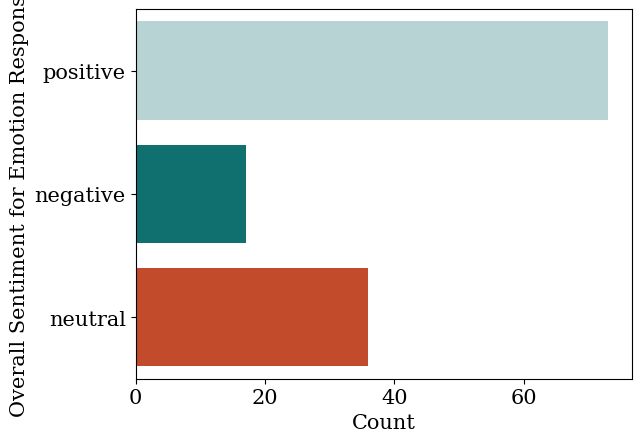

In [29]:
# 1. Calculate sentiment analysis on each emotion statement:
emo_sl42['senti'] = emo_sl42['emotion'].apply(sentiment_analysis)

# 2. Sort Sentiment Scores into Independent Columns
for idx in emo_sl42.index:
    assign_scores(idx)

# 3. Drop Unecessary Columns
emo_sl42 = emo_sl42.drop(columns=['senti'])

# 4. Calculate the dominant overall sentiment of the response
emo_sl42['emo_label'] = emo_sl42[['positive', 'negative', 'neutral']].idxmax(axis=1)

# 5. Plot the overall sentiments distribution
plot_sentiment_analysis(emo_sl42, 'emo')

## Comfort: LLM-based Overall Sentiment Analysis

In [33]:
comfort_sl42 = pd.read_csv('data/lab42_cleaned_data.csv', index_col=0).drop(columns = drop_col_emo, axis=1).dropna(subset=['comfort'])

In [37]:
def sentiment_analysis(sentence):
    return sentiment_task(sentence, top_k=3)

def assign_scores(idx):
    comfort_sl42.at[idx, 'positive'] = next(item for item in comfort_sl42['senti'][idx] if item['label'] == 'positive')['score']
    comfort_sl42.at[idx, 'negative'] = next(item for item in comfort_sl42['senti'][idx] if item['label'] == 'negative')['score']
    comfort_sl42.at[idx, 'neutral'] = next(item for item in comfort_sl42['senti'][idx] if item['label'] == 'neutral')['score']

def plot_sentiment_analysis(df, label):
    sns.countplot(y=df[label + "_label"], 
                  palette=['#b2d8d8',"#008080", '#db3d13'],
                  order=["positive", "negative", "neutral"])
    plt.ylabel("Overall Sentiment for Comfort Responses")
    plt.xlabel("Count")
    plt.savefig('plots/sentiment-analysis/students-lab42/' + label + '-llm-sentiment-count.jpg',
                dpi=300, bbox_inches='tight')

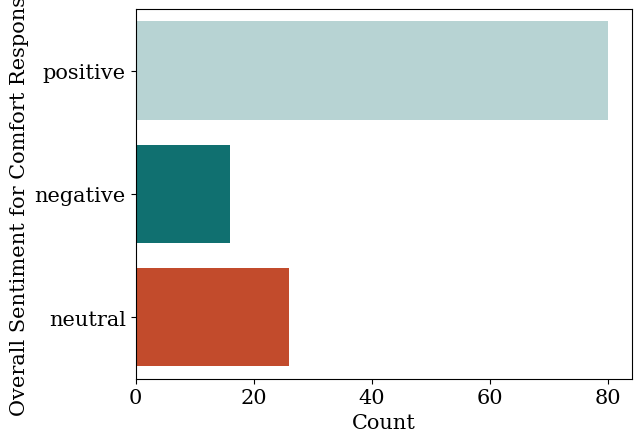

In [38]:
# 1. Calculate sentiment analysis on each emotion statement:
comfort_sl42['senti'] = comfort_sl42['comfort'].apply(sentiment_analysis)

# 2. Sort Sentiment Scores into Independent Columns
for idx in comfort_sl42.index:
    assign_scores(idx)

# 3. Drop Unecessary Columns
comfort_sl42 = comfort_sl42.drop(columns=['senti'])

# 4. Calculate the dominant overall sentiment of the response
comfort_sl42['comfort_label'] = comfort_sl42[['positive', 'negative', 'neutral']].idxmax(axis=1)

# 5. Plot the overall sentiments distribution
plot_sentiment_analysis(comfort_sl42, 'comfort')

# Comparing Emotion and Comfort Sentiments
How do positive emotion labels impact comfort? What about negative emo labels? Is there any relationship between the two?

## Lexicon-based Analysis using VADER
Here we are interested in the rule-based analysis. The compound score is computed by summing the 
valence scores of each word in the lexicon, adjusted according to the rules, and then normalized 
to be between -1 (most extreme negative) and +1 (most extreme positive). 
It is a 'normalized, weighted composite score.

In [ ]:
def vader_lexicon_analysis(df, label):
    analyzer = SentimentIntensityAnalyzer()
    df[label + '-composite-score'] = df[label].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
    
    return df 

def plot_lexicon_analysis(df, label):
    sns.boxplot(x='floor', y='emotion-composite-score', data=df)
    plt.xlabel("Floor")
    plt.ylabel("Lexicon-based Normalised Weighted Composite Score \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.tick_params(bottom=False)
    plt.axhline(0, ls='--', c = 'grey')
    plt.savefig('plots/sentiment-analysis/students-lab42/' +
                label +
                '-vader-lexicon-composite.jpg',
                dpi=300,
                bbox_inches='tight')

    plt.clf()

    sns.displot(x='emotion-composite-score', kde=True, 
                height=4,
                aspect=1.5,
                data=emo_sl42)
    plt.xlabel("Lexicon-Based Normalised Weighted Composite Scores for Sentiments \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.tick_params(bottom=False)
    plt.axhline(0, ls='--', c = 'grey')
    plt.savefig('plots/sentiment-analysis/students-lab42/' +
                label +
                '-distribution-lexicon-composite.jpg',
                dpi=300,
                bbox_inches='tight')
    plt.clf()

    sns.displot(x='emotion-composite-score', y='emo_label',
                binwidth=(.2, .1),
                height=4,
                aspect=1.5,
                data=emo_sl42)
    plt.xlabel("Lexicon-Based Normalised Weighted Composite Scores for Sentiments \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.ylabel("LLM Generated Sentiment Labels")
    plt.tick_params(bottom=False)
    plt.savefig('plots/sentiment-analysis/students-lab42/' +
                label +
                '-vader-vs-lexicon-composite.jpg',
                dpi=300,
                bbox_inches='tight')

def plot_sentiment_analysis_spaces(df, label):
    df = df.where(df["space-type"] != "").dropna(how="all")
    f = plt.figure(figsize=(10, 6))
    sns.boxplot(x='space-type', y='compound', width=0.5,
 data=df)
    plt.xlabel("Space Type")
    plt.ylabel("Sentiment Value \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.tick_params(bottom=False)
    plt.axhline(0, ls='--', c = 'grey')
    plt.savefig('plots/lab42-' + label + '-space-wise-sentiment-distribution.jpg',
                dpi=300, bbox_inches='tight')

In [ ]:
emo_sl42 = vader_lexicon_analysis(emo_sl42, 'emotion')
plot_lexicon_analysis(emo_sl42, 'emotion')

## Scale data to scores between -1 and 1
Polarity score in the range of -1 to -0.5 typically indicates negative sentiment
Polarity score greater than -0.5 and less than +0.5 typically indicates neutral sentiment
Polarity score in the range of +0.5 to 1 typically indicates positive sentiment

In [ ]:
def scale_emotion_values():
    labels = ['positive', 'negative', 'neutral']
    scales = [(0.5, 1.0), (-1.0, -0.5), (-0.5, 0.5)]
    emo_sl42['scaled_scores'] = 0
    
    for label, scale in zip(labels, scales):
        values = np.array(emo_sl42[label][emo_sl42['emo_label'] == label]).reshape(-1,1)
        idx = emo_sl42.index[emo_sl42['emo_label'] == label].to_list()
        scaled_values = minmax_scaler(scale, values, idx)
        emo_sl42.loc[idx,'scaled_scores'] = scaled_values
    
    return emo_sl42


def minmax_scaler(scale, values, idx):
    scaler = MinMaxScaler(feature_range = scale)
    scaled_values = pd.Series(scaler.fit_transform(values).flatten()).set_axis(idx)
    
    return scaled_values 

In [ ]:
emo_sl42 = scale_emotion_values()

In [ ]:
group = ['Round tables by the three plants (across wooden staircase)',
                        'Next to the lockers',
                        'Study corner next to the plant wall',
                        'Yellow/white chairs & tables (besides the wooden staircase)',
                        'Tables on the landing (with wooden floor) accessible by the black staircase',
                        'Green group study tables (between a row of plants and railing)',
                        'Group tables by the stairs',
                        'Open lounge area',
                        'Near the printer',
                        'Round tables by the coffee machine']

individual =  ['Library learning room',
                             'Green chairs by the entrance',
                             'Partly covered green chairs (along glass wall)']

unsure = ["Unsure"]

def assign_types_to_spaces(space):
    if space in group:
        return "group"
    if space in individual:
        return "individual"
    if space in unsure:
        return "unsure"
    
def merge_spaces(df):
    df["space-type"] = df["space-ground-floor"] + df["space-1-floor"] + df["space-2-floor"] + df["space-3-floor"]
    df = df.drop(columns =["space-ground-floor", "space-1-floor", "space-2-floor", "space-3-floor"])
    
    return df


def create_group_solo_space_labels(df):
    spaces = ["ground-floor", "1-floor", "2-floor", "3-floor"]
    
    for space in spaces:
        df["space-" + space] = df[space].apply(lambda space: assign_types_to_spaces(space)).fillna("")
    
    return df


def plot_sentiment_analysis_spaces(df, label):
    df = df.where(df["space-type"] != "").dropna(how="all")
    f = plt.figure(figsize=(10, 6))
    sns.boxplot(x='space-type', y='scaled_scores',
                width=0.5,
                data=df)
    plt.xlabel("Space Type")
    plt.ylabel("Sentiment Value \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.tick_params(bottom=False)
    plt.axhline(0, ls='--', c = 'grey')
    plt.savefig('plots/lab42-' + label + '-space-wise-sentiment-distribution.jpg',
                dpi=300, bbox_inches='tight')

In [ ]:
df = create_group_solo_space_labels(emo_sl42)
df = merge_spaces(df)
plot_sentiment_analysis_spaces(df, 'emotion')

In [ ]:
def plot_overview_sentiment_analysis_spaces(df, label):
    df = df.where(df["space-type"] != "").dropna(how="all")
    f = plt.figure(figsize=(10, 6))
    sns.catplot(data=df, 
                x="floor", y='scaled_scores',
                hue="emo_label",
                col="space-type",
                kind="swarm" )
    plt.xlabel("Floor")
    plt.ylabel("Scaled Sentiment Value \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.tick_params(bottom=False)
    plt.savefig('plots/lab42-' + label + 'floor-space-wise-sentiment-distribution.jpg',
                dpi=300, bbox_inches='tight')



# sns.countplot(y=emo_sl42["emo_label"], palette=['#b2d8d8',"#008080", '#db3d13'],order=["positive", "negative", "neutral"])

In [ ]:
plot_overview_sentiment_analysis_spaces(emo_sl42, "emo")

In [ ]:
emo_sl42['dominant_emo_val'] = emo_sl42[['positive', 'negative', 'neutral']].max(axis=1)


In [ ]:
sns.catplot(x='emo_label', y='dominant_emo_val', hue="space-type",
            kind="bar", errorbar=None, data=emo_sl42)

## Aspect-Based Sentiment Analysis

maybe train your own model: https://github.com/shwe24/Aspect-Based-Sentiment-Classification/blob/main/Aspect_Extraction.ipynb

In [ ]:
txt = emo_sl42.emotion[1]

In [ ]:
txt

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
from transformers import pipeline

In [ ]:
# Load Aspect-Based Sentiment Analysis model
absa_tokenizer = AutoTokenizer.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")
absa_model = AutoModelForSequenceClassification.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")

In [ ]:
txt = 'It’s quiet and not noisy. '

In [ ]:
# ABSA of "food"
aspect = "noisy"
inputs = absa_tokenizer(f"[CLS] {txt} [SEP] {aspect} [SEP]", return_tensors="pt")
outputs = absa_model(**inputs)
probs = F.softmax(outputs.logits, dim=1)
probs = probs.detach().numpy()[0]
print(f"Sentiment of aspect '{aspect}' is:")
for prob, label in zip(probs, ["negative", "neutral", "positive"]):
  print(f"Label {label}: {prob}")
print()

In [ ]:
# Overall sentiment of the sentence
sentiment = sentiment_task(txt)[0]
print(f"Overall sentiment: {sentiment['label']} with score {sentiment['score']}")
# Overall sentiment: Negative with score 0.7706006765365601

In [ ]:
txt = emo_sl42.emotion[148]

In [ ]:
text = word_tokenize(txt)

In [ ]:
nltk.pos_tag(text)

In [ ]:
import spacy
emo_aspect_terms = []

nlp = spacy.load("en_core_web_sm")


for review in nlp.pipe(emo_sl42.emotion):
    chunks = [(chunk.root.text) for chunk in review.noun_chunks if chunk.root.pos_ == 'CCONJ']
    emo_aspect_terms.append(' '.join(chunks))
emo_sl42['emo_aspect_terms'] = emo_aspect_terms

In [ ]:
emo_sl42.emo_aspect_terms

In [ ]:
txt

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")


In [ ]:
txt = "I’m a little cold, but otherwise calm and comfortable"

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp(txt)

for token in doc:
    print(token.text, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

In [ ]:
import spacy
from spacy.matcher import Matcher

nlp = spacy.load("en_core_web_sm")

matcher = Matcher(nlp.vocab)

patterns = [
    [{'POS':'ADJ'}],
    ]
matcher.add("demo", patterns)

doc = nlp(txt)
matches = matcher(doc)
for match_id, start, end in matches:
    string_id = nlp.vocab.strings[match_id]  # Get string representation
    span = doc[start:end]  # The matched span
    print(match_id, string_id, start, end, span.text)

In [ ]:
import spacy

txt = "I’m a little cold, but otherwise a bit calm and comfortable"
nlp = spacy.load("en_core_web_sm")
doc = nlp(txt)

for token in doc:
    print(token.text,token.pos_)


In [ ]:
from spacy.matcher import DependencyMatcher


pattern = [
  {
    "RIGHT_ID": "target",
    "RIGHT_ATTRS": {"POS": "ADJ"}
  },
  # founded -> subject
  {
    "LEFT_ID": "target",
    "REL_OP": ">",
    "RIGHT_ID": "modifier",
    "RIGHT_ATTRS": {"DEP": {"IN": ["amod", "nummod"]}}
  },
]

matcher = DependencyMatcher(nlp.vocab)
matcher.add("FOUNDED", [pattern])
txt = "I’m a little cold, but otherwise a bit calm and comfortable"
doc = nlp(txt)
for match_id, (target, modifier) in matcher(doc):
    print(doc[modifier], doc[target], sep="\t")

In [ ]:
noun_adj_pairs = {}
for chunk in doc.ad:
    adj = []
    noun = ""
    for tok in chunk:
        if tok.pos_ == "NOUN":
            noun = tok.text
        if tok.pos_ == "ADJ" or tok.pos_ == "CCONJ":
            adj.append(tok.text)
    if noun:
        noun_adj_pairs.update({noun:" ".join(adj)})

noun_adj_pairs
